# Automated Annotation Workflow

This workflow uses the auto_annot tools from besca to newly annotate a scRNAseq dataset based on one or more preannotated datasets. Ideally, these datasets come from a similar tissue and condition.

We use supervised machine learning methods to annotate each individual cell utilizing methods like support vector machines (SVM) or logistic regression.

First, the traning dataset(s) and the testing dataset are loaded from h5ad files or made available as adata objects. Next, the training and testing datasets are corrected using scanorama, and the training datasets are then merged into one anndata object. Then, the classifier is trained utilizing the merged training data. Finally, the classifier is applied to the testing dataset to predict the cell types. If the testing dataset is already annotated (to test the algorithm), a report including confusion matrices can be generated.

In [1]:
import besca as bc

In [2]:
import scanpy as sc

### load datasets

Apparently the scv loader makes sure the adata objects are all in comparable format whereas the sc loader loads them as is.

In [3]:
adata_test = bc.datasets.pbmc3k_processed()

In [4]:
adata_test_orig = bc.datasets.pbmc3k_processed()

In [5]:
adata_train1 = bc.datasets.Granja2019_processed()

In [6]:
adata_train2 = bc.datasets.Kotliarov2020_processed()

In [7]:
adata_train_list = [adata_train1, adata_train2]

need to rename column for classifier to find annotation

In [8]:
adata_train_list[1].obs["dblabel"] = adata_train_list[1].obs.celltype3

## Parameter specification

Give your analysis a name.

In [9]:
analysis_name = 'auto_annot_scanvi_comparison' # The analysis name will be used to name the output files

Specify column name of celltype annotation you want to train on.

In [10]:
celltype ='dblabel' # This needs to be a column in the .obs of the training datasets (and test dataset if you want to generate a report)

Choose a method:

- linear: Support Vector Machine with Linear Kernel
- sgd: Support Vector Machine with Linear Kernel using Stochastic Gradient Descent
- rbf: Support Vector Machine with radial basis function kernel. Very time intensive, use only on small datasets.
- logistic_regression: Standard logistic classifier iwth multinomial loss.
- logistic_regression_ovr: Logistic Regression with one versus rest classification.
- logistic_regression_elastic: Logistic Regression with elastic loss, cross validates among multiple l1 ratios.

In [11]:
method = 'logistic_regression'

Specify merge method. Needs to be either scanorama or naive.

In [12]:
merge = 'scanorama' # We recommend to use scanorama here

Decide if you want to use the raw format or highly variable genes. Raw increases computational time and does not necessarily improve predictions.

In [13]:
use_raw = False # We recommend to use False here

You can choose to only consider a subset of genes from a signature set or use all genes.

In [14]:
genes_to_use = 'all' # We suggest to use all here, but the runtime is strongly improved if you select an appropriate gene set

## Correct datasets (e.g. using scanorama) and merge training datasets

This function merges training datasets, removes unwanted genes, and if scanorama is used corrects for datasets.

In [16]:
adata_train, adata_test_corrected = bc.tl.auto_annot.merge_data(adata_train_list, adata_test, genes_to_use = genes_to_use, merge = merge)

merging with scanorama
using scanorama rn
Found 207 genes among all datasets
[[0.         0.69861833 0.47963259]
 [0.         0.         0.98881789]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)
integrating training set


In [17]:
adata_train.write("temp_anndata.h5ad")

... storing 'Group' as categorical
... storing 'initialClusters' as categorical
... storing 'Clusters' as categorical
... storing 'BioClassification' as categorical
... storing 'Barcode' as categorical
... storing 'Type' as categorical
... storing 'BioClassificationADT' as categorical
... storing 'leiden' as categorical
... storing 'celltype0' as categorical
... storing 'celltype1' as categorical
... storing 'celltype2' as categorical
... storing 'celltype3' as categorical
... storing 'dblabel' as categorical
... storing 'CELL' as categorical
... storing 'CONDITION' as categorical
... storing 'sample_type' as categorical
... storing 'donor' as categorical
... storing 'tenx_lane' as categorical
... storing 'cohort' as categorical
... storing 'timepoint' as categorical
... storing 'protein_leiden' as categorical
... storing 'leiden_r1.0' as categorical
... storing 'celltype_flowjo' as categorical


In [18]:
adata_test_corrected.write("temp_anndata_test.h5ad")

In [15]:
adata_train = sc.read("temp_anndata.h5py")

ValueError: Reading with filekey 'temp_anndata.h5py' failed, the inferred filename PosixPath('write/temp_anndata.h5py.h5ad') does not exist. If you intended to provide a filename, either use a filename ending on one of the available extensions {'mtx', 'tsv', 'data', 'loom', 'tab', 'mtx.gz', 'soft.gz', 'h5', 'xlsx', 'anndata', 'h5ad', 'txt', 'csv'} or pass the parameter `ext`.

## Train the classifier

The returned scaler is fitted on the training dataset (to zero mean and scaled to unit variance). The scaling will then be applied to the counts in the testing dataset and then the classifier is applied to the scaled testing dataset (see next step, adata_predict()). This function will run multiple jobs in parallel if if logistic regression was specified as method.

In [19]:
classifier, scaler = bc.tl.auto_annot.fit(adata_train, method, celltype, njobs=10)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  6.2min finished


## Prediction

If in addition to the most likely class you would like to have all class probabilities returned use the following function. (This is only a sensible choice if using logistic regression.)

In [20]:
adata_predicted_aa = bc.tl.auto_annot.adata_pred_prob(classifier = classifier, scaler = scaler, adata_pred = adata_test_corrected, adata_orig = adata_test_orig, threshold = 0.0)

## Prediction with scANVI

In [24]:
adata_train, adata_pred_sc, adata_concat = bc.tl.auto_annot.scanvi_predict(adata_train_list, adata_test, celltype)

setting up anndata for sciv
INFO     Using batches from adata.obs["batch"]                                               
INFO     Using labels from adata.obs["scvi_training_labels"]                                 
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 84828 cells, 207 vars, 3 batches, 
         26 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is trained.                          
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
train lvae
INFO     Training Unsupervised Trainer for 94 epochs.                                        
INFO     Training Sem

In [37]:
adata_pred_sc.obs["auto_annot"] = adata_predicted_aa.obs["auto_annot"].values

## Output

The adata object that includes the predicted cell type annotation can be written out as h5ad file.

In [56]:
adata_pred_sc.write('./adata_predicted_auto_annot_scANVI.h5ad')

In [43]:
adata_pred_sc.write('/mnt/c/Users/luisw/OneDrive/Dokumente/BEDA/adata_predicted_auto_annot_scANVI.h5ad')

In [46]:
adata_pred = sc.read('./adata_predicted_auto_annot_scANVI.h5ad')

## Reporting

Confusion matrix, without normalization
Normalized confusion matrix


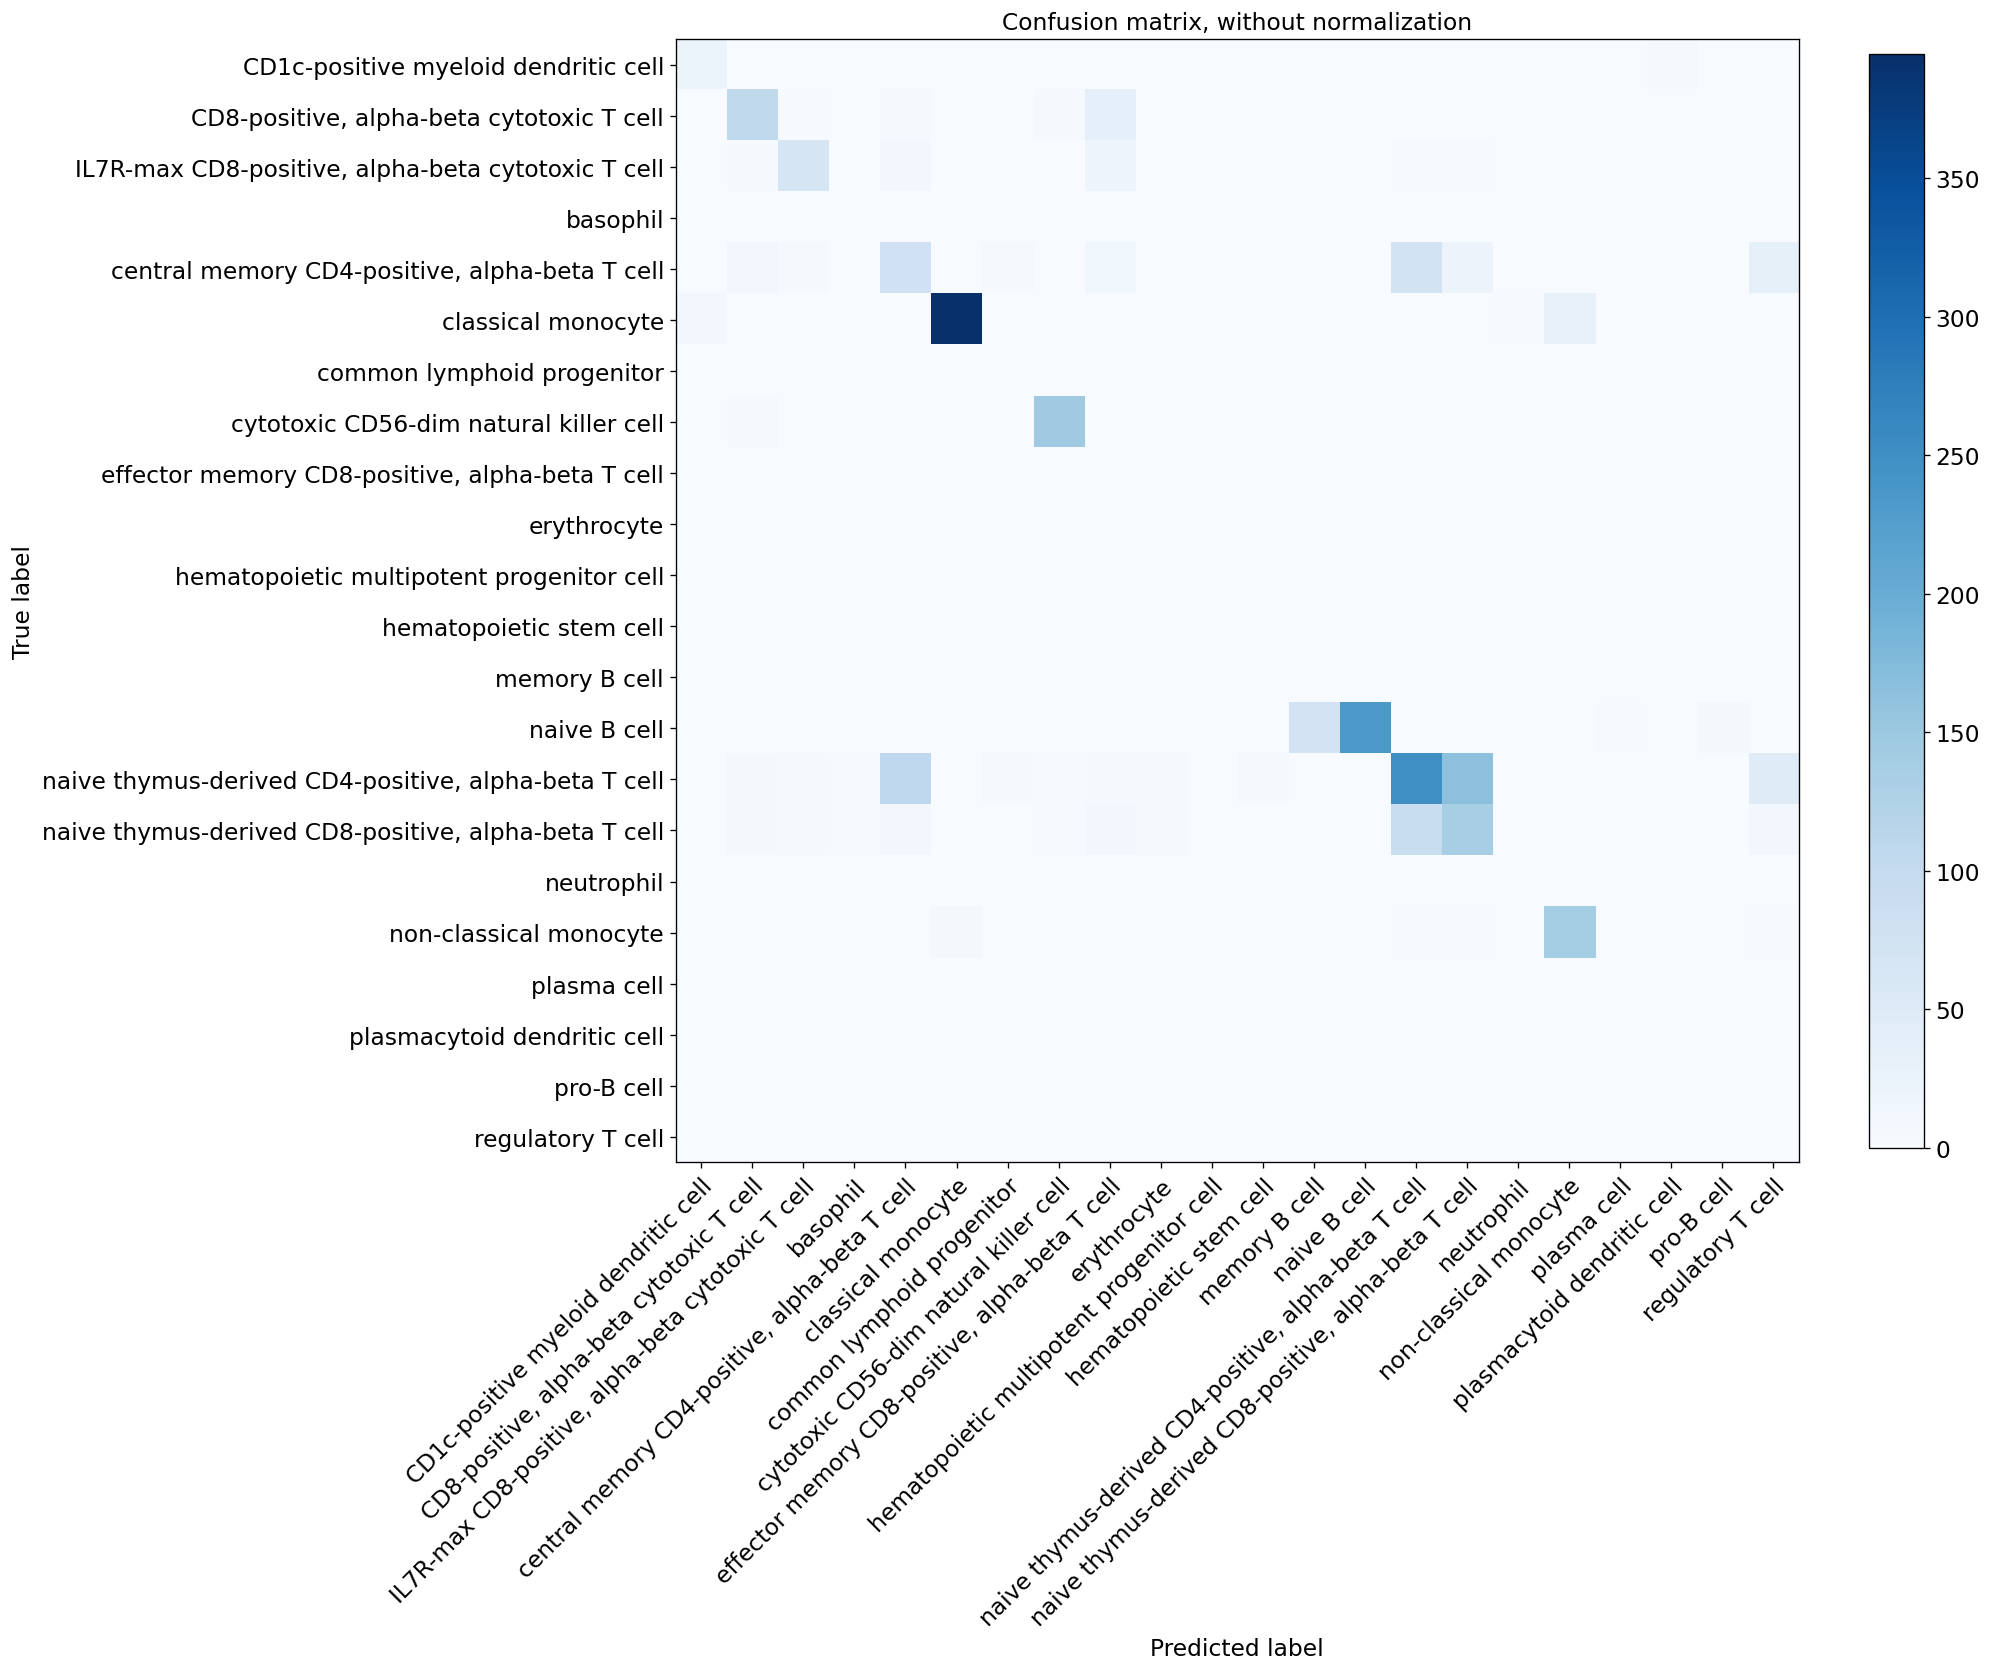

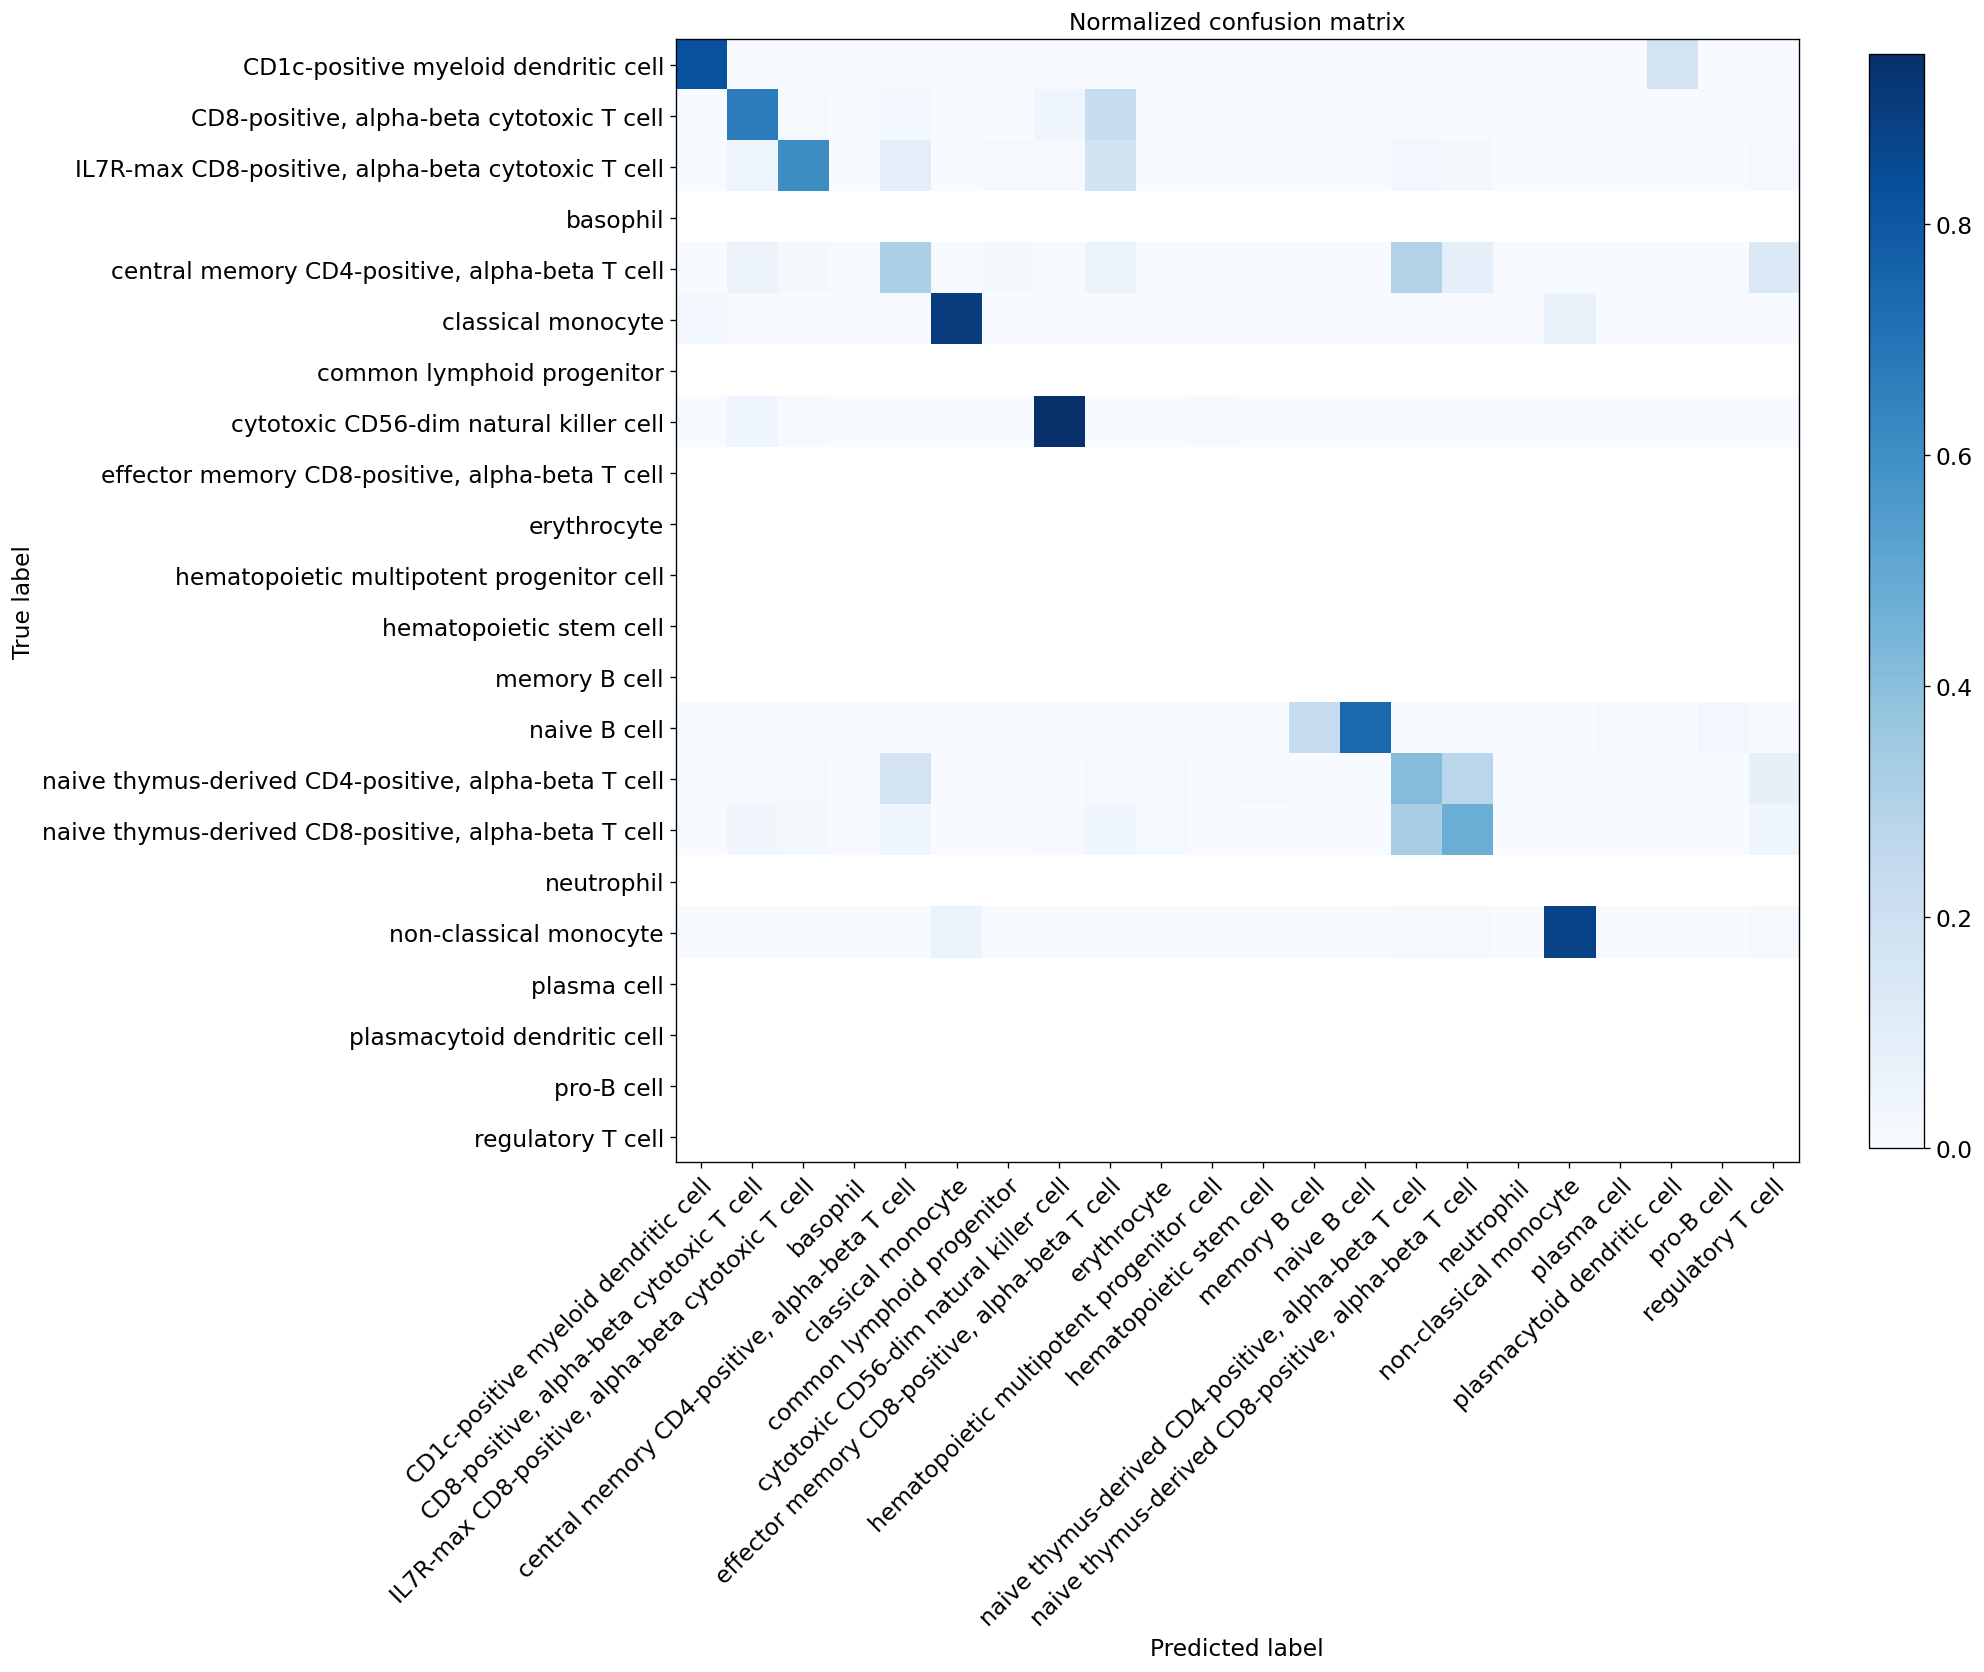

In [55]:
bc.tl.report(
    adata_pred,
    celltype,
    method,
    analysis_name,
    ["Granja2019_processed", "Kotliarov2020_processed"],
    "pbmc3k_processed",
    "logistic_regression",
    name_prediction="auto_annot",
    name_report="auto_annot_comparison",
    use_raw=False,
    genes_to_use="all",
    remove_nonshared=False,
    clustering="leiden",
    asymmetric_matrix=False,
)

Confusion matrix, without normalization
Normalized confusion matrix


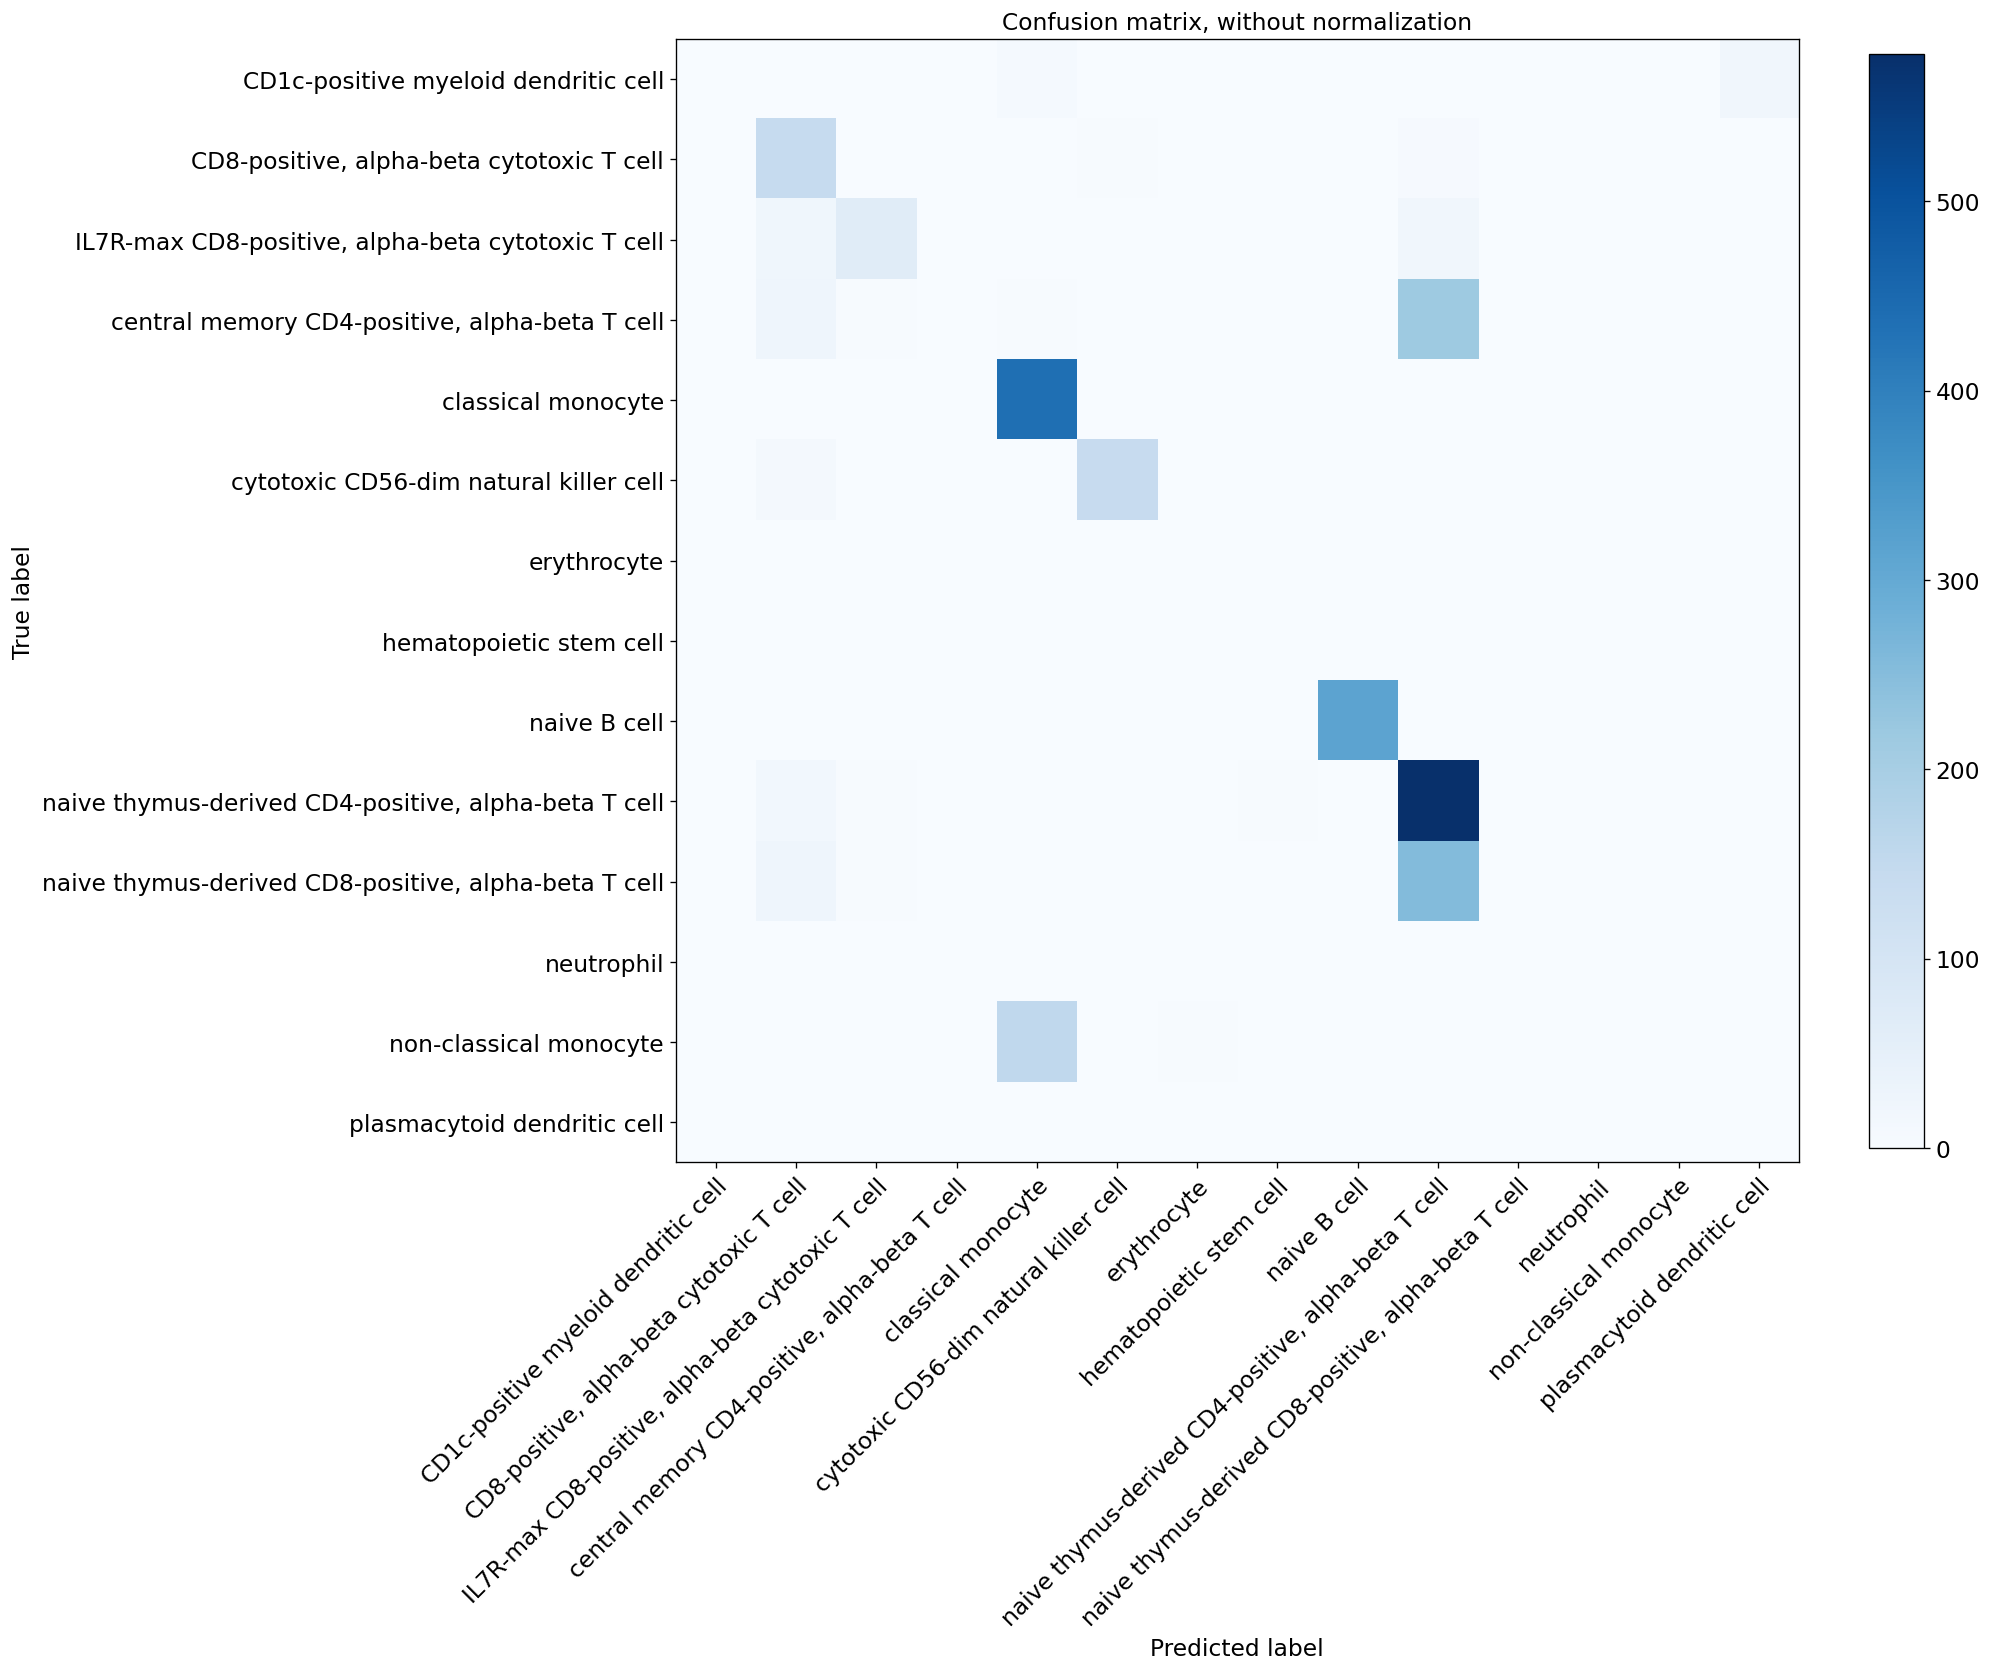

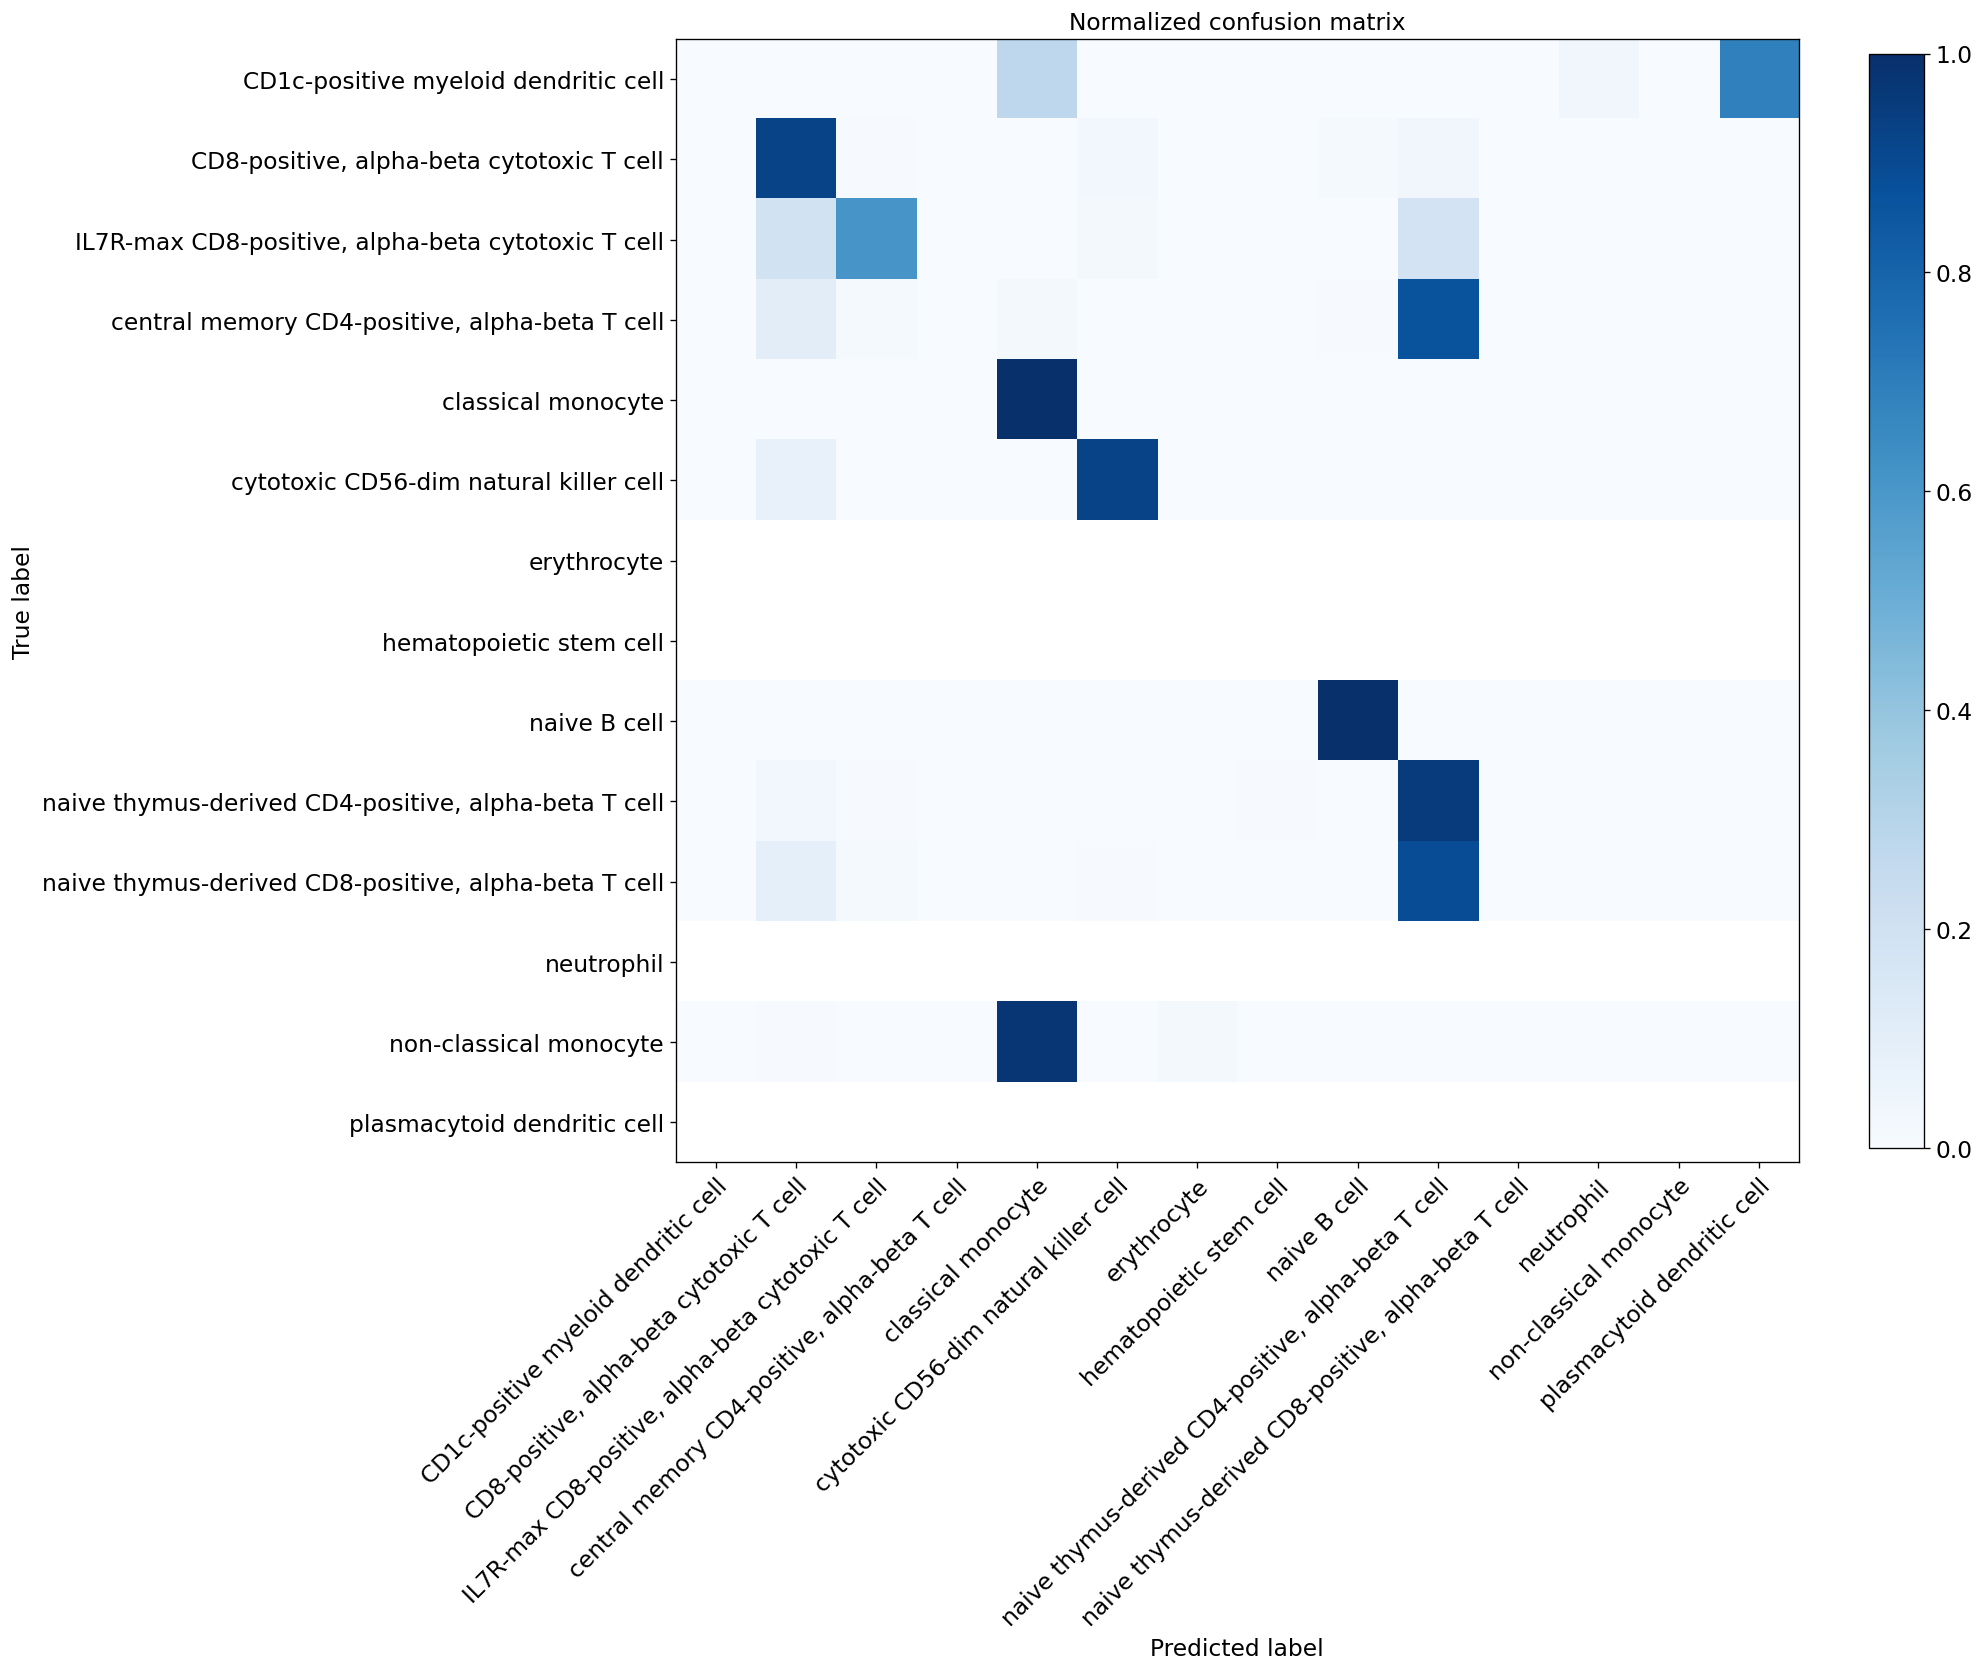

In [54]:
bc.tl.report(
    adata_pred,
    "dblabel",
    "scANVI",
    analysis_name,
    ["Granja2019_processed", "Kotliarov2020_processed"],
    "pbmc3k_processed",
    "scANVI",
    name_prediction="C_scANVI",
    name_report="scANVI_comparison",
    use_raw=True,
    genes_to_use="all",
    remove_nonshared=False,
    clustering="leiden",
    asymmetric_matrix=False,
)

In [52]:
import os
os.getcwd()

'/mnt/c/Users/luisw/OneDrive/Dokumente/BEDA/bescafinal/besca_publication_results/hematopoietic/auto_annot'

## for later

If the testing dataset included already a cell type annotation, a report can be generated and written, which includes metrics,  confusion matrices and comparative umap plots.

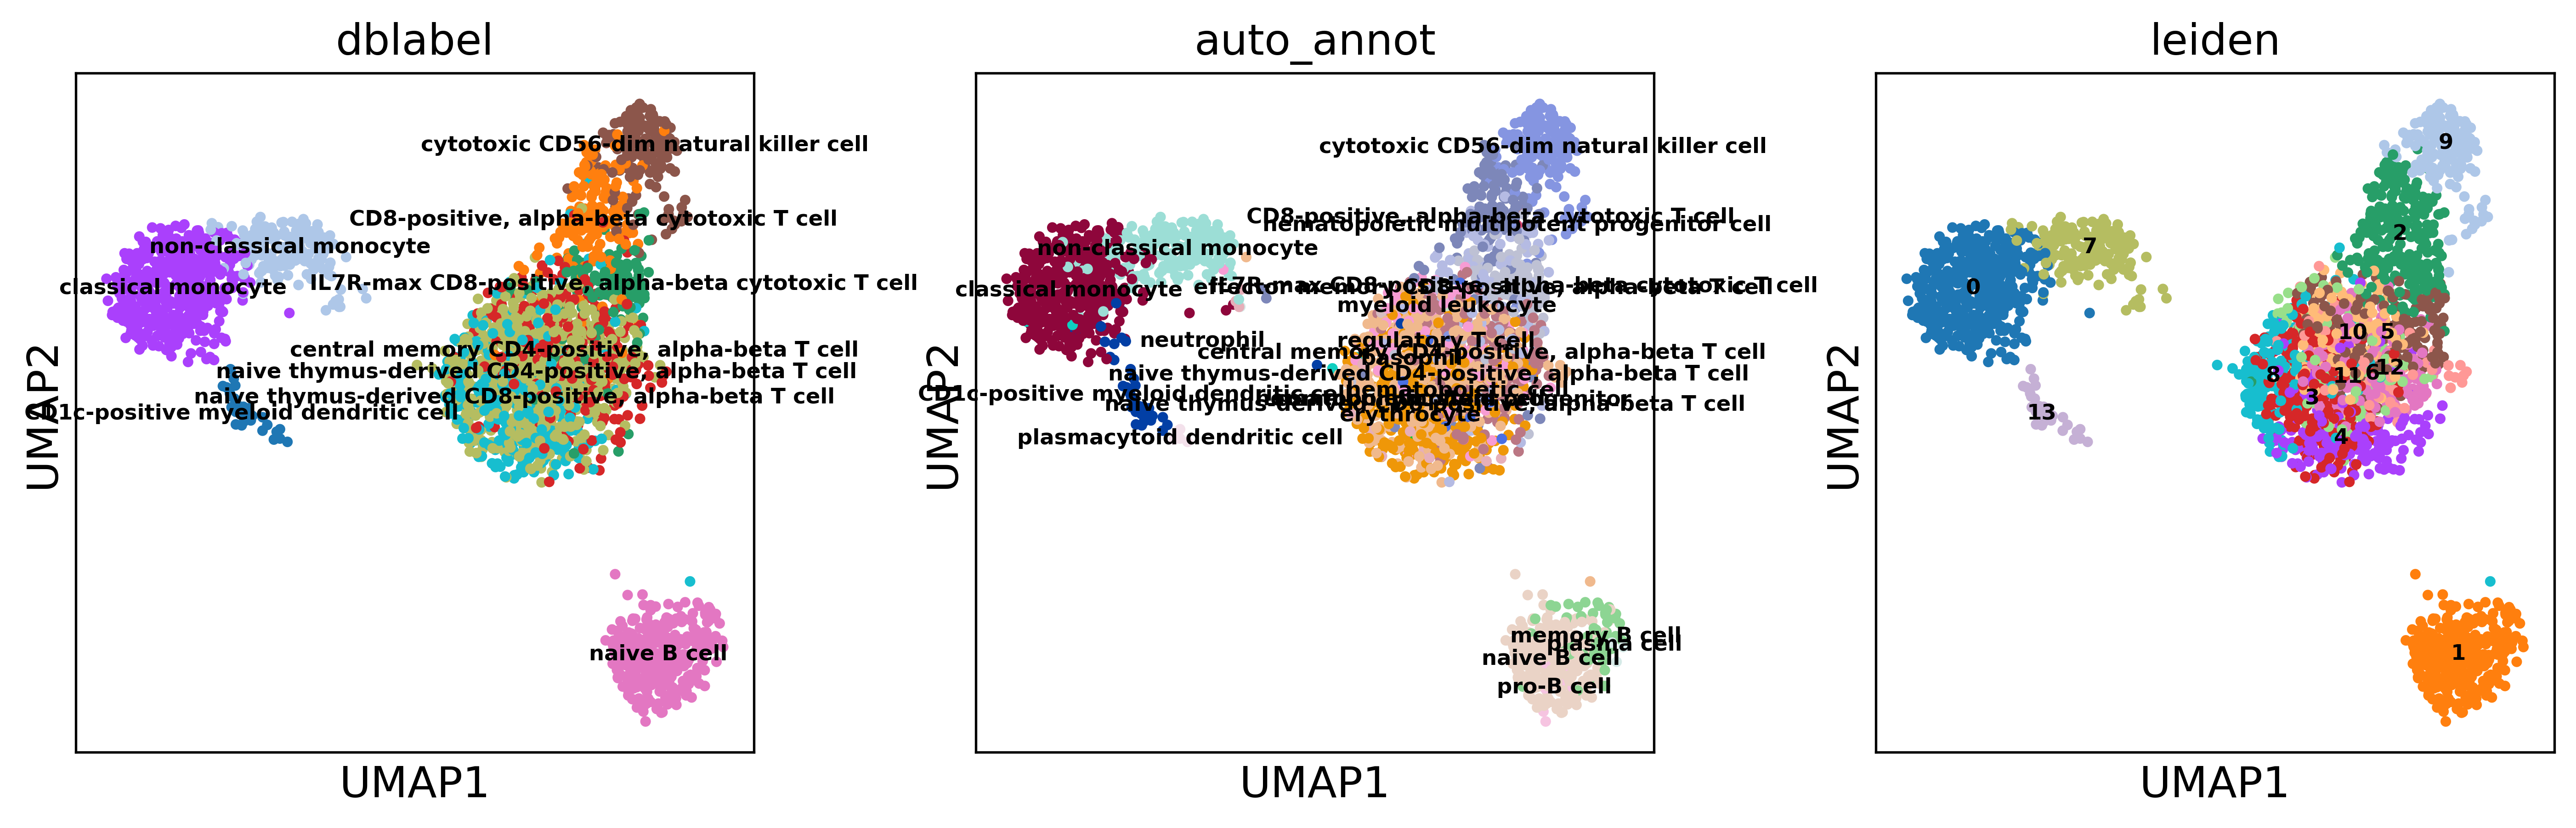

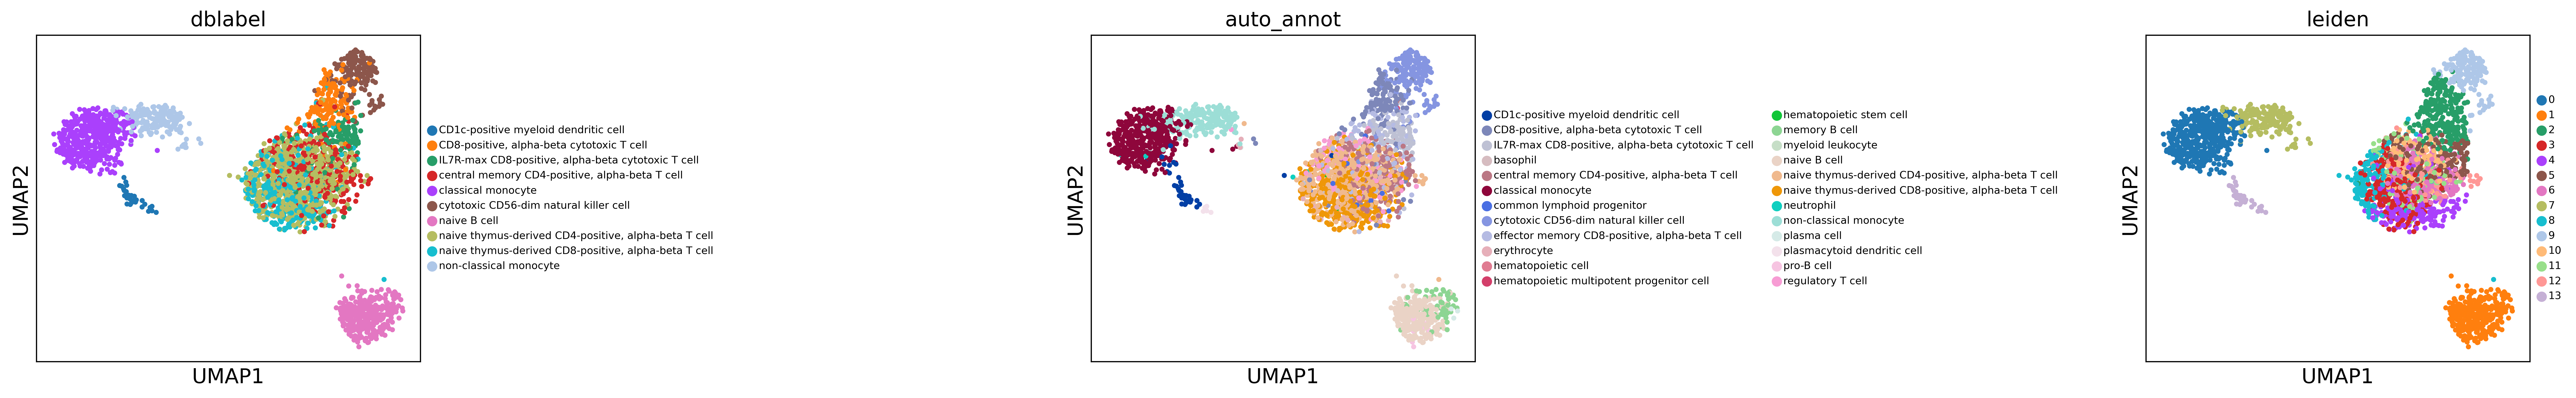

Confusion matrix, without normalization
Normalized confusion matrix


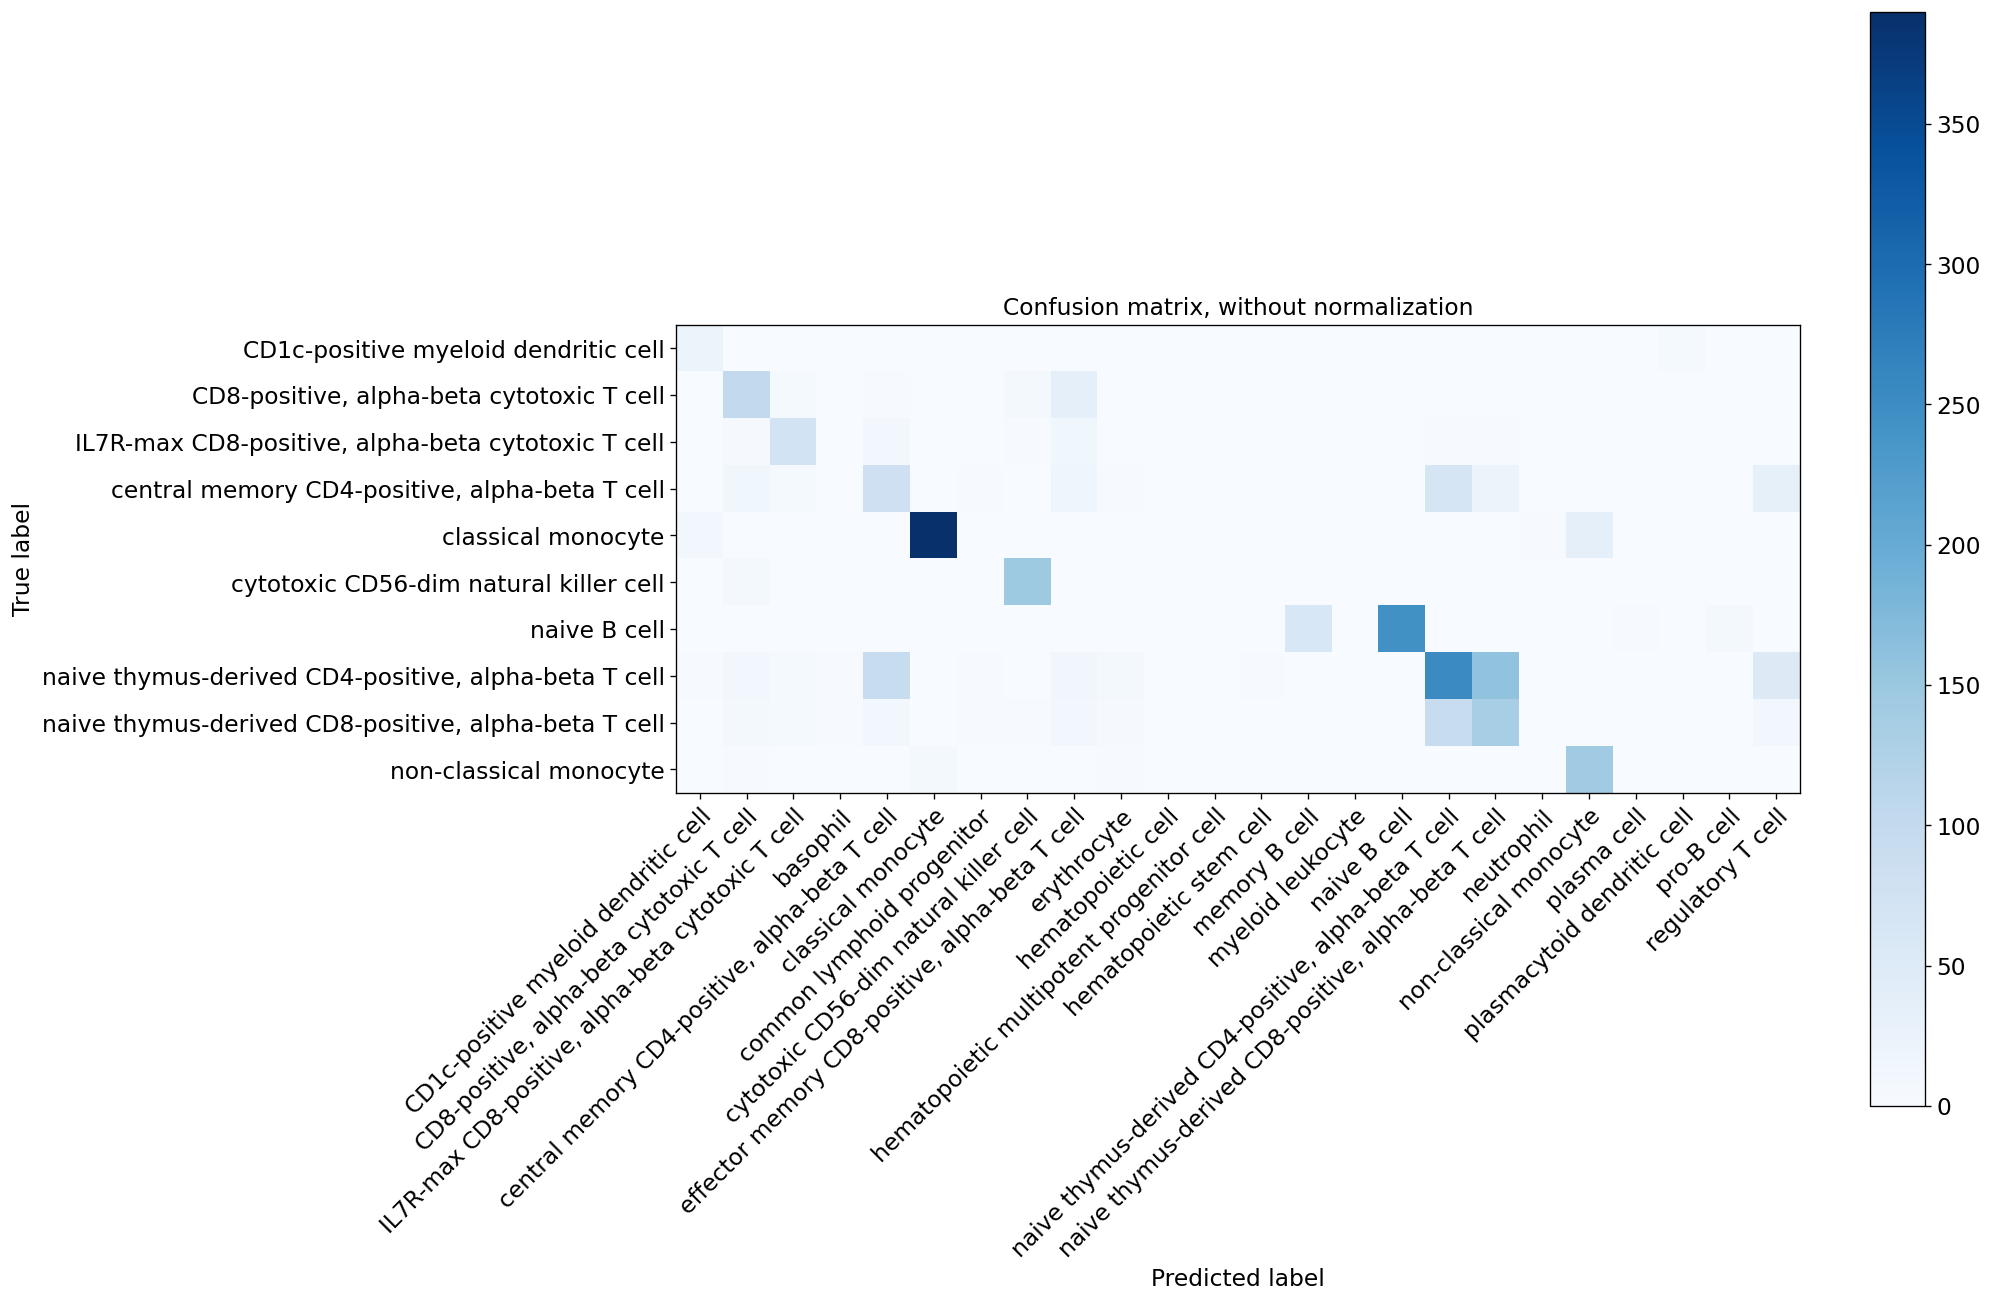

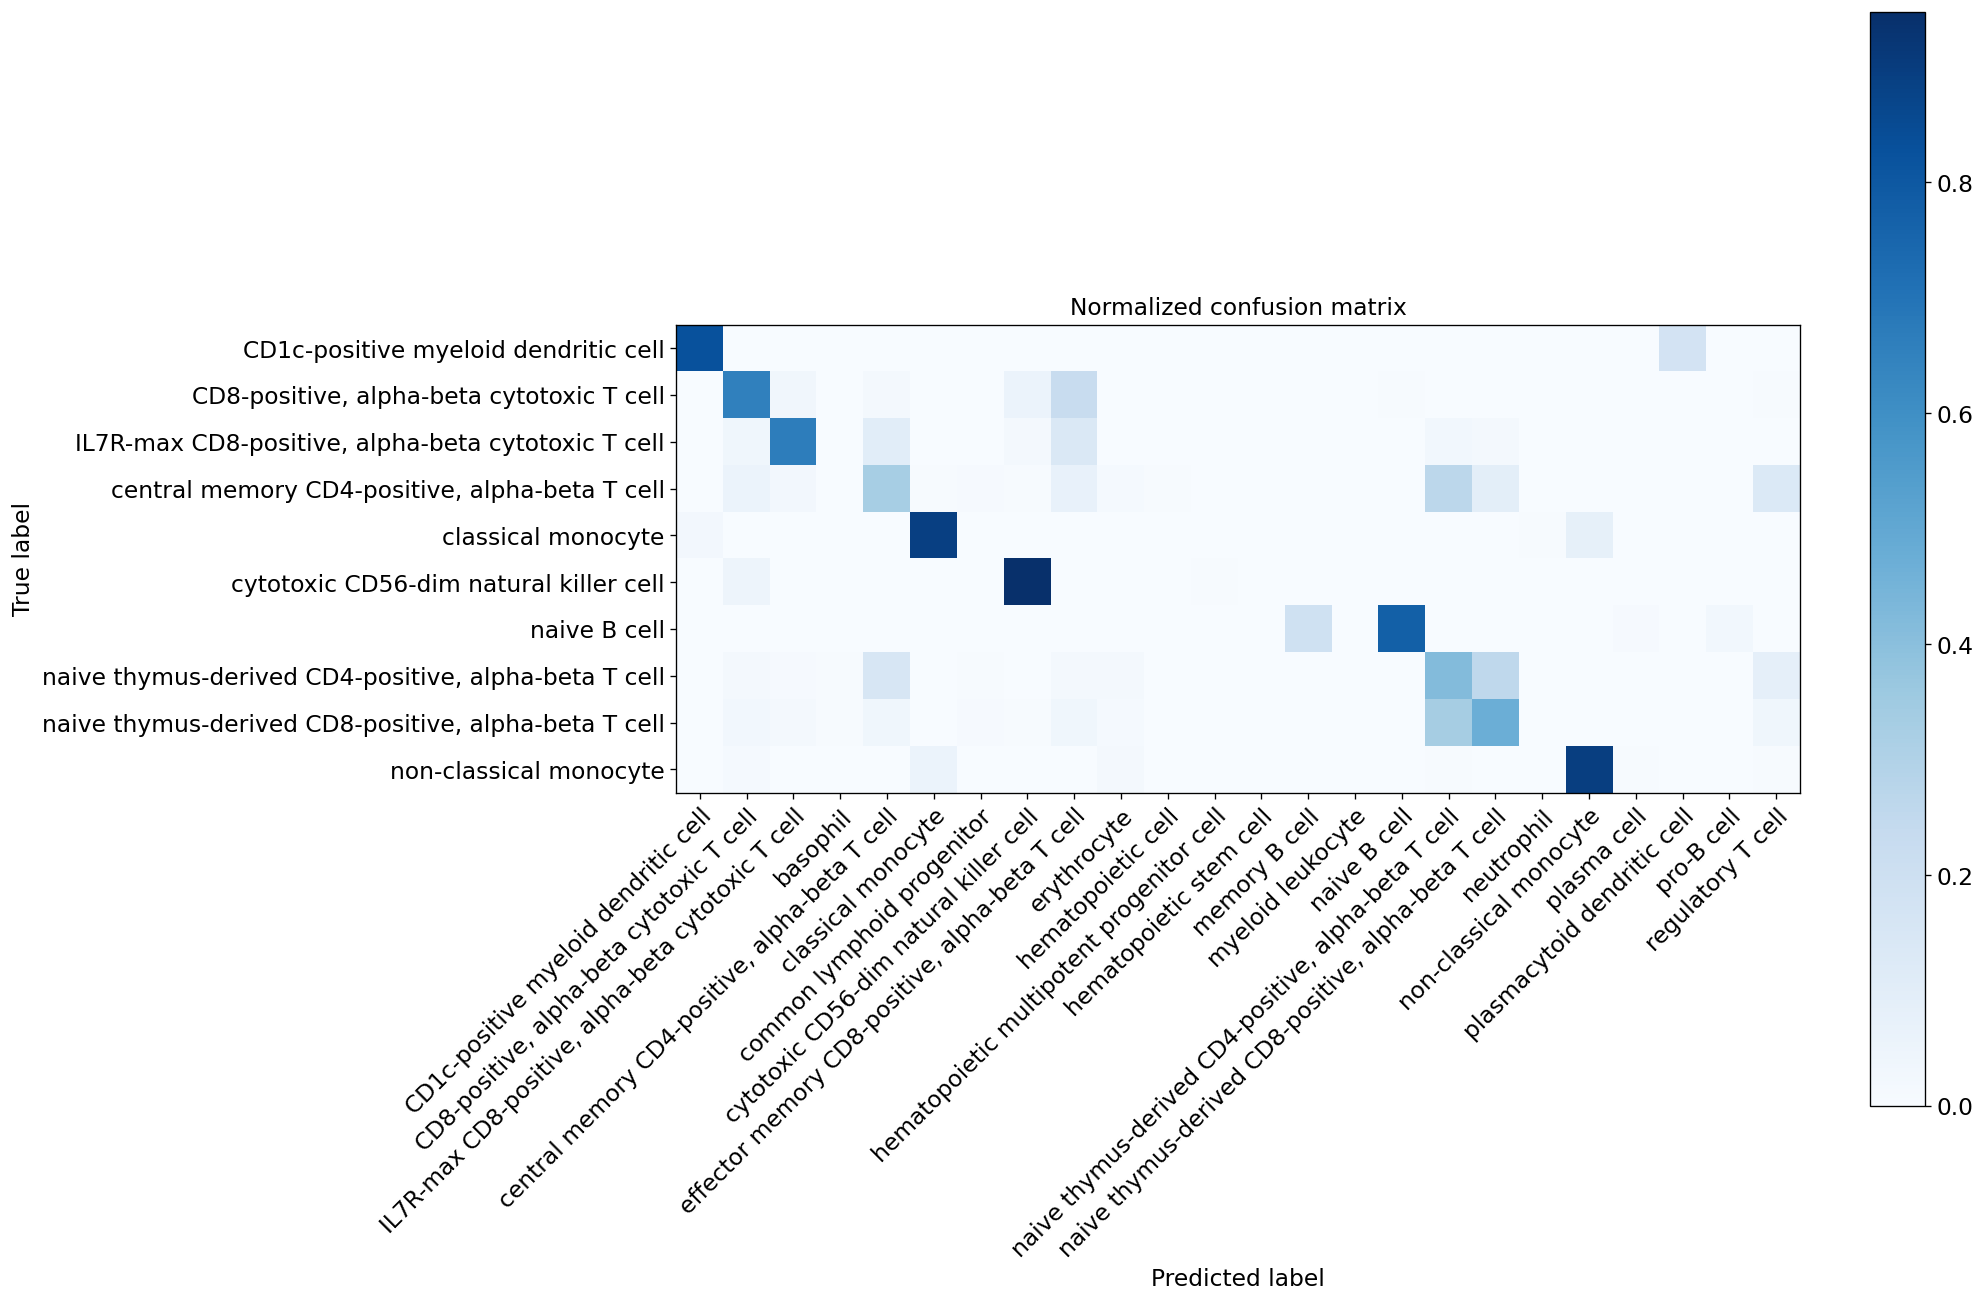

In [34]:
%matplotlib inline
import scanpy as sc
sc.settings.set_figure_params(dpi=90)
bc.tl.auto_annot.report(adata_predicted, celltype, method, analysis_name, False, merge, use_raw, genes_to_use, clustering = 'leiden')

In [72]:
sc.settings.set_figure_params(dpi=80) 
plt.rcParams['svg.fonttype'] = 'none'

sc.pl.umap(adata_predicted, color=[celltype, 'auto_annot', 'leiden'], legend_loc='on data',legend_fontsize=7,  save= '.fig3_ondata.svg')
sc.pl.umap(adata_predicted, color=[celltype, 'auto_annot', 'leiden'],legend_fontsize=7, wspace = 1.4, save = '.fig3.svg')


In [15]:
# make conf matrices (4)

#for publication plot font size adjustment
sc.settings.set_figure_params(dpi=80) 
plt.rcParams['svg.fonttype'] = 'none'
class_names =  np.unique(np.concatenate((adata_predicted.obs[celltype], adata_predicted.obs['auto_annot'])))
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(adata_predicted.obs[celltype], adata_predicted.obs['auto_annot'], title = " ", classes=class_names, celltype=celltype ,numbers = False, adata_predicted = adata_predicted, asymmetric_matrix = True)
plt.savefig(os.path.join('fig3_confusion_matrix_nonnormalised.svg'))

# Plot normalized confusion matrix with numbers
plot_confusion_matrix(adata_predicted.obs[celltype], adata_predicted.obs['auto_annot'], title = " ", classes=class_names,celltype=celltype,  normalize=True, numbers = False, adata_predicted = adata_predicted, asymmetric_matrix = True)
plt.savefig(os.path.join('fig3_confusion_matrix_normalised.svg'))


Confusion matrix, without normalization
Normalized confusion matrix
